# Simulation of Dropout and protein contamination.¶

In [1]:
import sys
import dpi
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tqdm import tqdm
import scipy.stats

2022-12-10 22:27:43.006941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-10 22:27:43.006987: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Read data and model
* The "CBMC.pkl" can be downloaded at [DPI data warehouse](http://101.34.64.251:88/).
* Note: The version of tensorflow and tensorflow-estimator must be 2.7.0. Otherwise, the following code will not execute properly.

In [3]:
cbmc = dpi.loadobj("CBMC.pkl")

2022-12-10 22:27:52.971729: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-10 22:27:52.971778: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-10 22:27:52.971807: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ecs-r-ai): /proc/driver/nvidia/version does not exist
2022-12-10 22:27:52.972069: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


All analysis results of CBMC dataset are saved in "cbmc" variable.

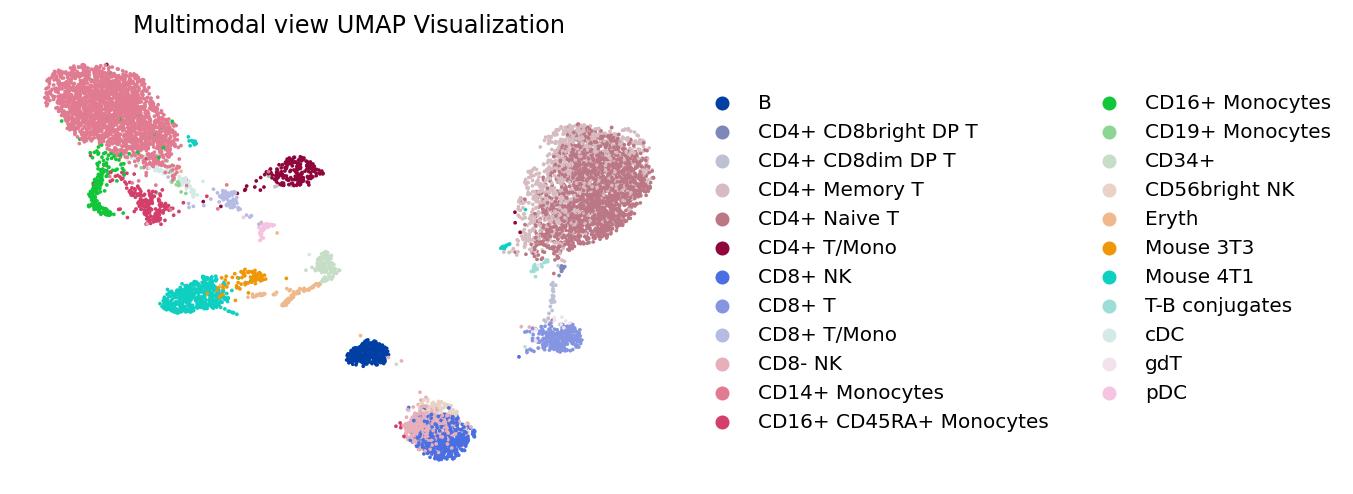

In [4]:
sc.pl.umap(cbmc, color="celltype_MO", frameon=False, title="Multimodal view UMAP Visualization")

# Simulating the Dropout of rna data

In [5]:
rna_markers = ["CD3E", "CD4", "CD8A", "PTPRC", "NCAM1", "FCGR3A", "ITGAX", "CD14", "CD19", "CD34"]

In [6]:
def simulate_rna_droupout(sc_data, zero_ratio=0.80, quantile_threshold=0.25):
    rna_data = sc_data.obsm["rna_nor"]
    ran_dropout_data = np.zeros(rna_data.shape)
    
    for i in tqdm(range(rna_data.shape[0])):
        # Extract all RNA from a cell
        cell_rna_data = rna_data[i].copy()
        # Get the index of non-zero RNA
        nonzero_index = cell_rna_data > 0
        # The quartile of non-zero RNA is defined as the threshold of low expression
        low_rna_expression = np.quantile(cell_rna_data[nonzero_index], quantile_threshold, interpolation='lower')
        
        # Check each RNA
        for j in range(cell_rna_data.shape[0]):
            # RNAs with expression below the threshold have a certain probability (zero_ratio) of being set to zero.
            if cell_rna_data[j]<low_rna_expression and np.random.choice(100,1)[0]/100<zero_ratio:
                cell_rna_data[j] = 0

        ran_dropout_data[i] = cell_rna_data
    
    sc_data.obsm["rna_nor"] = ran_dropout_data

Simulating Dropoout of RNA data.

In [7]:
cbmc_with_rna_dropout = dpi.loadobj("CBMC.pkl")

Genes expressed in less than quartiles per cell have a 90% chance of Dropout (being set to zero).

In [8]:
simulate_rna_droupout(cbmc_with_rna_dropout, zero_ratio=0.90)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8617/8617 [15:20<00:00,  9.36it/s]


## Training model using Dropout's RNA data (with protein data)

In [10]:
dpi.build_mix_model(cbmc_with_rna_dropout, net_dim_rna_list=[512, 128], net_dim_pro_list=[128], net_dim_rna_mean=128, net_dim_pro_mean=128, net_dim_mix=128, lr=0.0001)

In [11]:
dpi.fit(cbmc_with_rna_dropout, batch_size=256)

Epoch 1/500
31/31 [==============================] - 10s 91ms/step - loss: 12817.5879 - val_loss: 2841.4539
Epoch 2/500
31/31 [==============================] - 2s 71ms/step - loss: -1428.1716 - val_loss: -4801.2090
Epoch 3/500
31/31 [==============================] - 2s 70ms/step - loss: -6904.4316 - val_loss: -8213.2881
Epoch 4/500
31/31 [==============================] - 2s 71ms/step - loss: -9383.7373 - val_loss: -9850.7285
Epoch 5/500
31/31 [==============================] - 2s 70ms/step - loss: -10799.4111 - val_loss: -10923.5420
Epoch 6/500
31/31 [==============================] - 2s 71ms/step - loss: -11724.8018 - val_loss: -11728.1855
Epoch 7/500
31/31 [==============================] - 2s 70ms/step - loss: -12355.3291 - val_loss: -12292.8350
Epoch 8/500
31/31 [==============================] - 2s 70ms/step - loss: -12817.2588 - val_loss: -12660.8125
Epoch 9/500
31/31 [==============================] - 2s 71ms/step - loss: -13116.7354 - val_loss: -12924.1250
Epoch 10/500
31/31

In [24]:
dpi.get_denoised_rna(cbmc_with_rna_dropout)
dpi.get_denoised_pro(cbmc_with_rna_dropout)

## Visualization

In [45]:
sc.pp.neighbors(cbmc_with_rna_dropout, use_rep="mix_features")
dpi.umap_run(cbmc_with_rna_dropout, min_dist=0.4)
sc.tl.leiden(cbmc_with_rna_dropout)

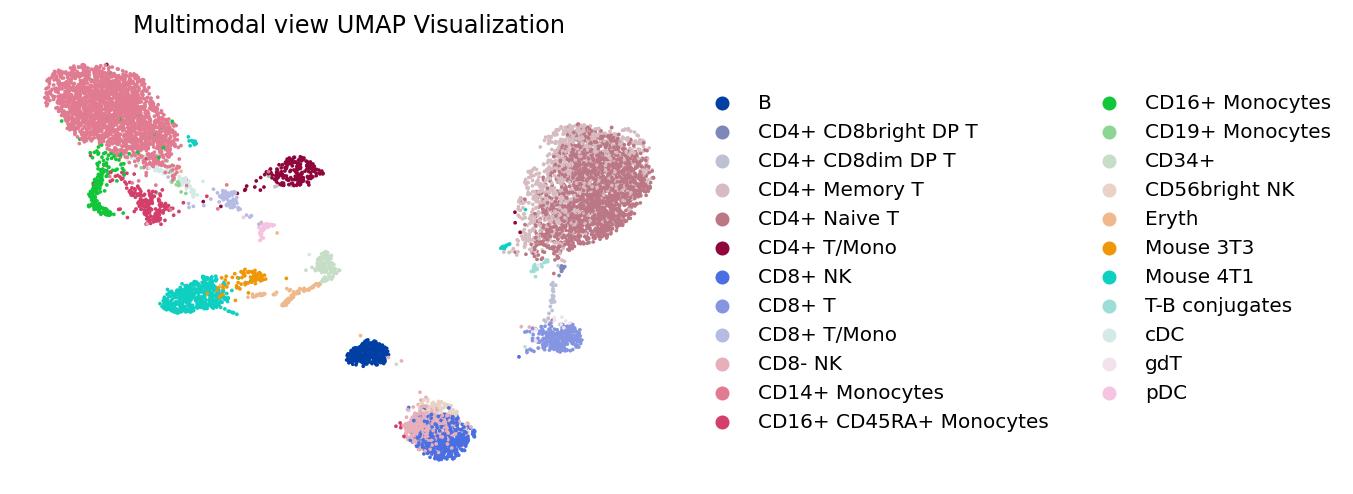

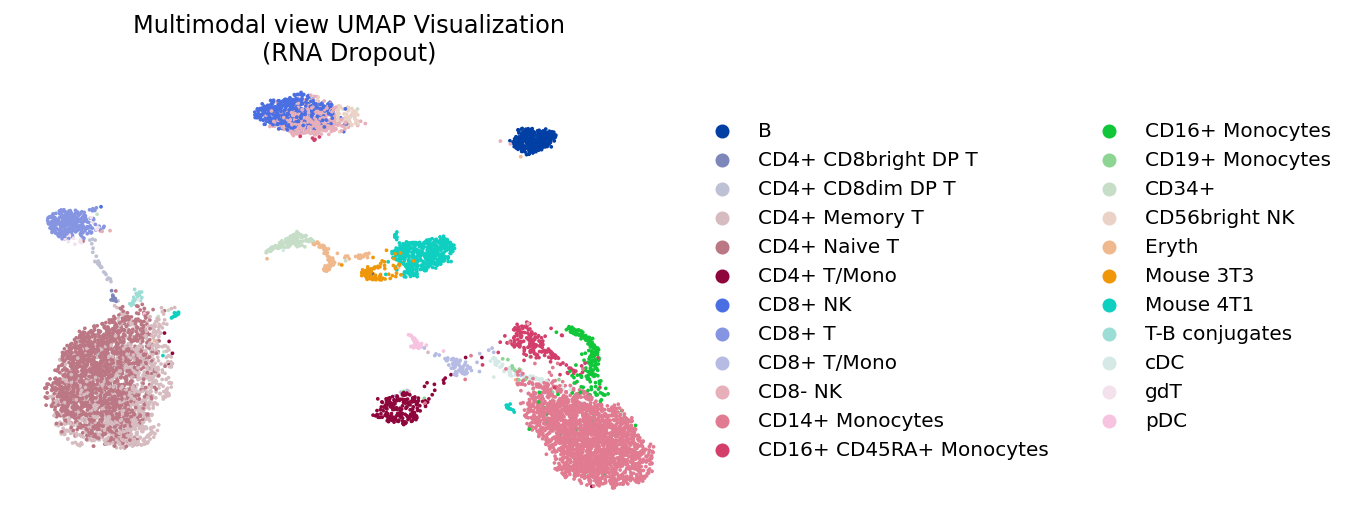

In [83]:
sc.pl.umap(cbmc, color="celltype_MO", frameon=False, title="Multimodal view UMAP Visualization")
sc.pl.umap(cbmc_with_rna_dropout, color="celltype_MO", frameon=False, title="Multimodal view UMAP Visualization\n(RNA Dropout)")

In [13]:
dpi.saveobj2file(cbmc_with_rna_dropout, "cbmc_with_rna_dropout.pkl")

2022-12-10 23:01:49.595483: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://8fa7f08a-343e-4125-9415-400baea64e4a/assets
INFO:tensorflow:Assets written to: ram://ac9441c5-b64d-49c7-9113-c7f66f5f6975/assets
INFO:tensorflow:Assets written to: ram://a90e5a42-a6d9-41f1-a4fc-70db3051f7a6/assets


'save obj to cbmc_with_rna_dropout.pkl'

# Simulating the protein contamination

In [15]:
cbmc_with_protein_contamination = dpi.loadobj("CBMC.pkl")

In [16]:
pro_markers = cbmc_with_protein_contamination.uns['adt']

In [17]:
def simulate_protein_contamination(sc_data, contamination_intensity=0.2):
    protein_data = sc_data.obsm["pro_nor"]
    # All proteins are affected by a certain percentage (contamination_intensity) of the maximum intensity (maximum value of 1) applied.
    protein_contamination_data = protein_data + np.random.randint(-100,100,size=protein_data.shape)*0.01*contamination_intensity
    # The definition domain of normalized protein data is 0 to 1. Data that does not conform to the domain is corrected.
    protein_contamination_data[protein_contamination_data>1] = 1
    protein_contamination_data[protein_contamination_data<0] = 0
    
    sc_data.obsm["pro_nor"] = protein_contamination_data

All protein data are randomly applied with 20% intensity of contamination.

In [18]:
simulate_protein_contamination(cbmc_with_protein_contamination, contamination_intensity=0.2)

## Training model using contaminated protein data (with RNA data)

In [20]:
dpi.build_mix_model(cbmc_with_protein_contamination, net_dim_rna_list=[512, 128], net_dim_pro_list=[128], net_dim_rna_mean=128, net_dim_pro_mean=128, net_dim_mix=128, lr=0.0001)

In [21]:
dpi.fit(cbmc_with_protein_contamination, batch_size=256)

Epoch 1/500
31/31 [==============================] - 10s 90ms/step - loss: 14576.2510 - val_loss: 3031.7898
Epoch 2/500
31/31 [==============================] - 2s 71ms/step - loss: -1041.8645 - val_loss: -4334.8887
Epoch 3/500
31/31 [==============================] - 2s 70ms/step - loss: -6493.0073 - val_loss: -7908.7881
Epoch 4/500
31/31 [==============================] - 2s 70ms/step - loss: -9136.9893 - val_loss: -9742.7178
Epoch 5/500
31/31 [==============================] - 2s 71ms/step - loss: -10640.2207 - val_loss: -10887.3477
Epoch 6/500
31/31 [==============================] - 2s 71ms/step - loss: -11625.7705 - val_loss: -11706.4756
Epoch 7/500
31/31 [==============================] - 2s 71ms/step - loss: -12284.8086 - val_loss: -12254.4990
Epoch 8/500
31/31 [==============================] - 2s 71ms/step - loss: -12720.3506 - val_loss: -12624.9717
Epoch 9/500
31/31 [==============================] - 2s 71ms/step - loss: -13019.3711 - val_loss: -12879.4697
Epoch 10/500
31/31

In [30]:
dpi.get_denoised_rna(cbmc_with_protein_contamination)
dpi.get_denoised_pro(cbmc_with_protein_contamination)

## Visualization

In [71]:
sc.pp.neighbors(cbmc_with_protein_contamination, use_rep="mix_features")
dpi.umap_run(cbmc_with_protein_contamination, min_dist=0.4)
sc.tl.leiden(cbmc_with_protein_contamination)

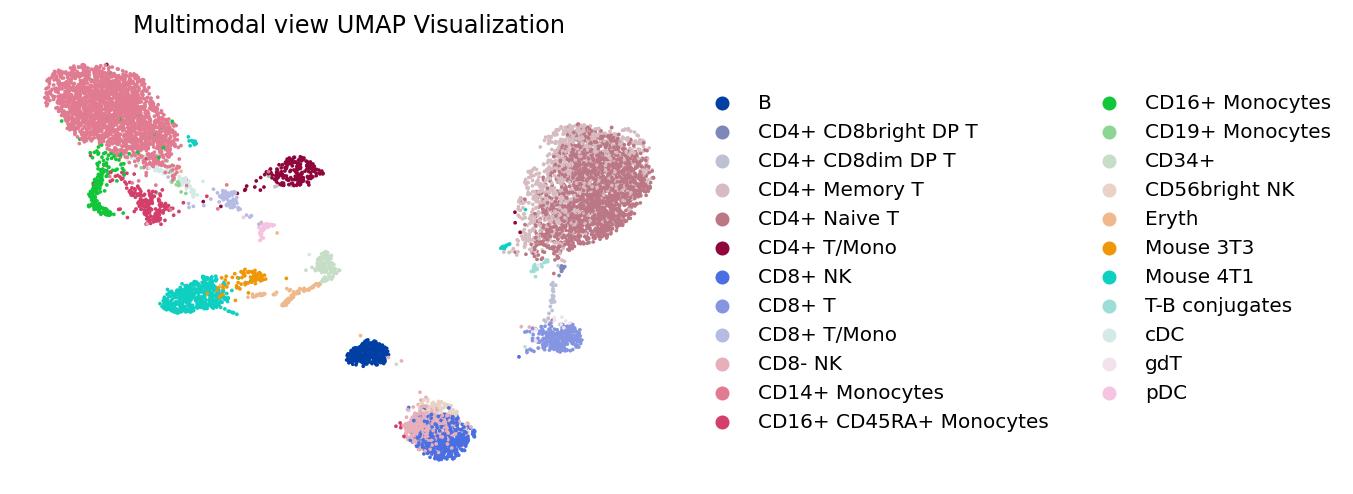

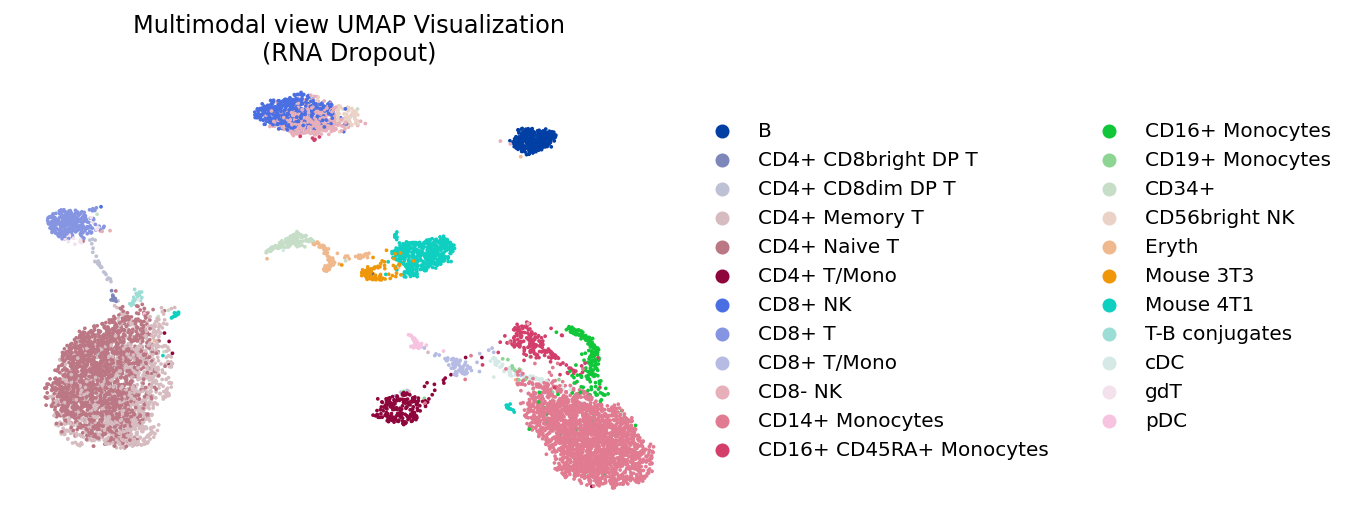

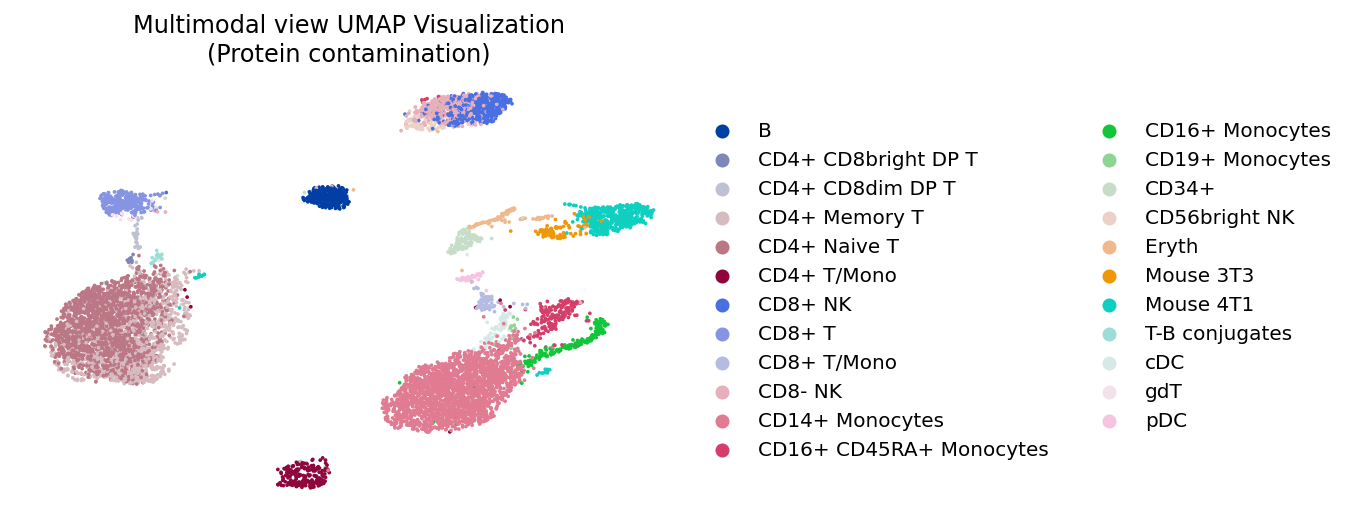

In [84]:
sc.pl.umap(cbmc, color="celltype_MO", frameon=False, title="Multimodal view UMAP Visualization")
sc.pl.umap(cbmc_with_rna_dropout, color="celltype_MO", frameon=False, title="Multimodal view UMAP Visualization\n(RNA Dropout)")
sc.pl.umap(cbmc_with_protein_contamination, color="celltype_MO", frameon=False, title="Multimodal view UMAP Visualization\n(Protein contamination)")

In [23]:
dpi.saveobj2file(cbmc_with_protein_contamination, "cbmc_with_protein_contamination.pkl")

INFO:tensorflow:Assets written to: ram://b70d5559-e15a-446a-8206-83d4ec8c56e6/assets
INFO:tensorflow:Assets written to: ram://86dfa7a2-dca0-4ec5-8435-c503c72bebdd/assets
INFO:tensorflow:Assets written to: ram://aaaf905f-56f1-492b-97b0-1a0f2f693b24/assets


'save obj to cbmc_with_protein_contamination.pkl'